# Speed testing for mode manipulators (TidalPy.tides)


In [1]:
from time import time as timer
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from TidalPy import version
from TidalPy.tides.mode_manipulation import find_mode_manipulators

In [3]:
N_range = np.logspace(0, 6, 10, dtype=np.int)
order_ls = {'-': 2, '--': 3, '-.': 4}
eccen_truncs = {'b': 2, 'g': 6, 'orange': 10, 'r': 20}

radius = 1.e6
gravity = 9.3
density = 1000.
shear_modulus = 50.e9
tidal_scale = 1.
tidal_susceptibility = 1.e22
tidal_host_mass = 1.e27
constant_cmplex_compliance = shear_modulus**(-1) + 1.0j * (shear_modulus*0.1)**(-1)
orbital_freq = 2. * np.pi / (86400. * 6)
spin_freq = 1.1 * orbital_freq

In [4]:
eccen_run_times = dict()
inclin_run_times = dict()
calculate_run_times = dict()
collapse_run_times = dict()

eccen_compile_times = list()
inclin_compile_times = list()
calculate_compile_times = list()
collapse_compile_times = list()
cases = list()

for ls, order_l in order_ls.items():
    for color, eccen_trunc in eccen_truncs.items():

        cases.append((order_l, eccen_trunc))

        calculate_terms, collapse_modes, eccentricity_func, inclination_func = \
            find_mode_manipulators(order_l, eccen_trunc, True)

        # Compile Time Calculations
        x = np.linspace(0.1, 0.9, 5)
        spin_freq_x = spin_freq * np.ones_like(x)
        orb_freq_x = orbital_freq * np.ones_like(x)
        semi_a_x = orb_freq_x**(-1)
        tidal_susceptibility_x = tidal_susceptibility * np.ones_like(semi_a_x)

        eccen_compile_t0 = timer()
        eccen_res = eccentricity_func(x)
        eccen_compile_time = timer() - eccen_compile_t0
        eccen_compile_times.append(eccen_compile_time)

        inclin_compile_t0 = timer()
        obliquity_res = inclination_func(x)
        inclin_compile_time = timer() - inclin_compile_t0
        inclin_compile_times.append(inclin_compile_time)

        calculate_terms_t0 = timer()
        freqs, results = calculate_terms(spin_freq_x, orb_freq_x, semi_a_x, radius, eccen_res, obliquity_res)
        calculate_compile_time = timer() - calculate_terms_t0
        calculate_compile_times.append(calculate_compile_time)

        complex_comp = tuple([constant_cmplex_compliance for _ in freqs])

        collapse_modes_t0 = timer()
        output = \
            collapse_modes(gravity, radius, density, shear_modulus, tidal_scale, tidal_host_mass,
                           tidal_susceptibility_x, complex_comp, results, order_l, cpl_ctl_method=False)
        collapse_compile_time = timer() - collapse_modes_t0
        collapse_compile_times.append(collapse_compile_time)

        # Run Time Calculations
        eccen_run_time_avg_at_case = list()
        inclin_run_time_avg_at_case = list()
        calculate_time_avg_at_case = list()
        collapse_time_avg_at_case = list()
        eccen_run_time_std_at_case = list()
        inclin_run_time_std_at_case = list()
        calculate_time_std_at_case = list()
        collapse_time_std_at_case = list()
        for N in N_range:
            x = np.linspace(0.1, 0.9, N)
            spin_freq_x = spin_freq * np.ones_like(x)
            orb_freq_x = orbital_freq * np.ones_like(x)
            semi_a_x = orb_freq_x**(-1)
            tidal_susceptibility_x = tidal_susceptibility * np.ones_like(semi_a_x)

            eccen_res = eccentricity_func(x)
            obliquity_res = inclination_func(x)
            freqs, results = calculate_terms(spin_freq_x, orb_freq_x, semi_a_x, radius, eccen_res, obliquity_res)
            complex_comp = tuple([constant_cmplex_compliance for _ in freqs])
            output = \
                collapse_modes(gravity, radius, density, shear_modulus, tidal_scale, tidal_host_mass,
                               tidal_susceptibility_x, complex_comp, results, order_l, cpl_ctl_method=False)

            eccen_timing = %timeit -o eccentricity_func(x)
            inclin_timing = %timeit -o inclination_func(x)
            calculate_timing = %timeit -o calculate_terms(spin_freq_x, orb_freq_x, semi_a_x, radius,\
                eccen_res, obliquity_res)
            collapse_timing = %timeit -o collapse_modes(gravity, radius, density, shear_modulus, tidal_scale,\
                tidal_host_mass, tidal_susceptibility_x, complex_comp, results, order_l, cpl_ctl_method=False)

            eccen_run_time_avg_at_case.append(eccen_timing.average)
            inclin_run_time_avg_at_case.append(inclin_timing.average)
            calculate_time_avg_at_case.append(calculate_timing.average)
            collapse_time_avg_at_case.append(collapse_timing.average)
            eccen_run_time_std_at_case.append(eccen_timing.stdev)
            inclin_run_time_std_at_case.append(inclin_timing.stdev)
            calculate_time_std_at_case.append(calculate_timing.stdev)
            collapse_time_std_at_case.append(collapse_timing.stdev)

        key = (ls, order_l, color, eccen_trunc)
        eccen_run_times[key] = (np.asarray(eccen_run_time_avg_at_case), np.asarray(eccen_run_time_std_at_case))
        inclin_run_times[key] = (np.asarray(inclin_run_time_avg_at_case), np.asarray(inclin_run_time_std_at_case))
        calculate_run_times[key] = (np.asarray(calculate_time_avg_at_case), np.asarray(calculate_time_std_at_case))
        collapse_run_times[key] = (np.asarray(collapse_time_avg_at_case), np.asarray(collapse_time_std_at_case))

62.5 µs ± 497 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
59.6 µs ± 522 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
170 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
24.3 µs ± 221 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
59.8 µs ± 174 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
59.6 µs ± 192 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
168 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
23.5 µs ± 133 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
60.4 µs ± 833 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
63.5 µs ± 2.98 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
202 µs ± 18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
32.5 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
63.2 µs ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
65 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs

### Plot Compile Times

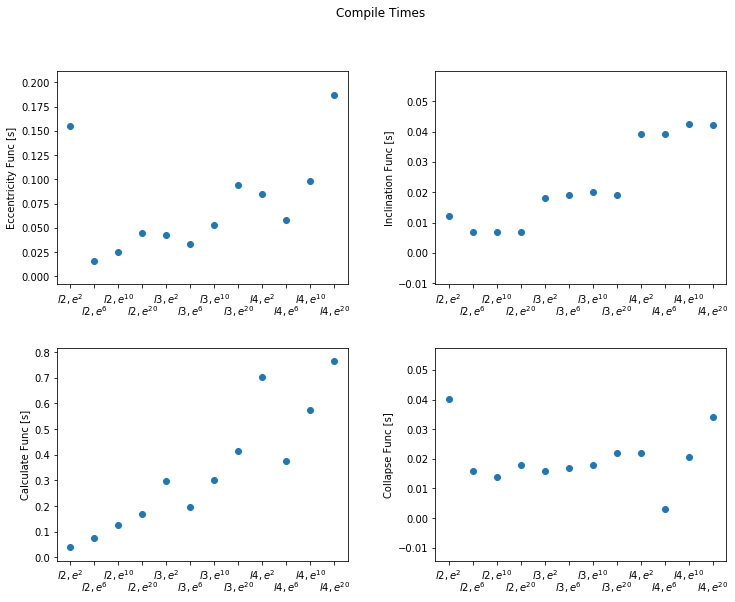

In [5]:
fig_compile, ax_compile = plt.subplots(2, 2, gridspec_kw={'wspace':0.3, 'hspace':0.3}, figsize=(12, 9))
fig_compile.suptitle('Compile Times')
ax_compile_eccen = ax_compile[0, 0]
ax_compile_inclin = ax_compile[0, 1]
ax_compile_calculate = ax_compile[1, 0]
ax_compile_collapse = ax_compile[1, 1]

ax_compile_eccen.set(ylabel='Eccentricity Func [s]')
ax_compile_inclin.set(ylabel='Inclination Func [s]')
ax_compile_calculate.set(ylabel='Calculate Func [s]')
ax_compile_collapse.set(ylabel='Collapse Func [s]')

x_names = ['$l' + f'{order_l}, ' + 'e^{' + f'{trunc}' + '}$' if i%2==0 else '\n$l' + f'{order_l}, ' + 'e^{' + f'{trunc}' + '}$' for i, (order_l, trunc) in enumerate(cases)]

ax_compile_eccen.scatter(range(len(x_names)), eccen_compile_times)
ax_compile_inclin.scatter(range(len(x_names)), inclin_compile_times)
ax_compile_calculate.scatter(range(len(x_names)), calculate_compile_times)
ax_compile_collapse.scatter(range(len(x_names)), collapse_compile_times)

for ax in [ax_compile_eccen, ax_compile_inclin, ax_compile_calculate, ax_compile_collapse]:

    ax.set_xticks(range(len(x_names)))
    ax.set_xticklabels(x_names)

plt.show()
fig_compile.savefig(f'CompileTimePlot_{version}.pdf')

### Plot Run Times

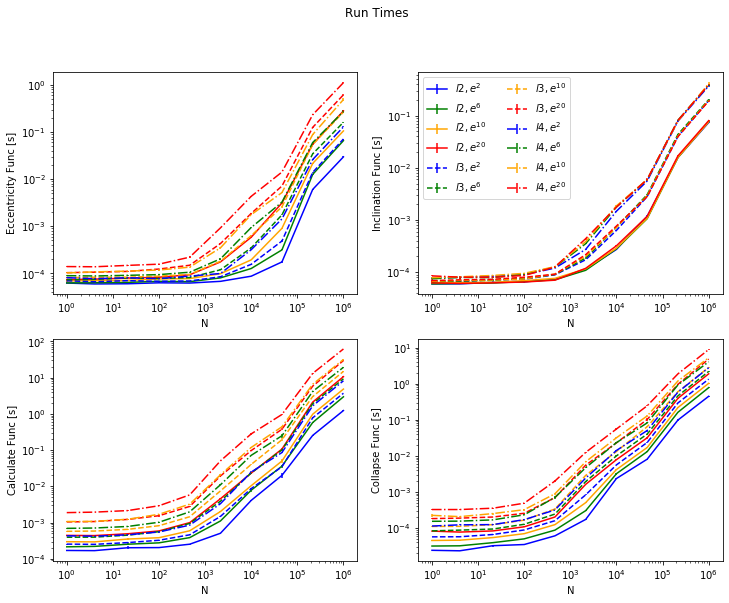

In [9]:
fig_runtime, ax_runtime = plt.subplots(2, 2, gridspec_kw={'wspace':0.2, 'hspace':0.2}, figsize=(12, 9))
fig_runtime.suptitle('Run Times')
ax_runtime_eccen = ax_runtime[0, 0]
ax_runtime_inclin = ax_runtime[0, 1]
ax_runtime_calculate = ax_runtime[1, 0]
ax_runtime_collapse = ax_runtime[1, 1]

ax_runtime_eccen.set(ylabel='Eccentricity Func [s]')
ax_runtime_inclin.set(ylabel='Inclination Func [s]')
ax_runtime_calculate.set(ylabel='Calculate Func [s]')
ax_runtime_collapse.set(ylabel='Collapse Func [s]')

for ax in [ax_runtime_eccen, ax_runtime_inclin, ax_runtime_calculate, ax_runtime_collapse]:
    ax.set(xlabel='N', xscale='log', yscale='log')

for key, (eccen_avg, eccen_std) in eccen_run_times.items():
    inclin_avg, inclin_std = inclin_run_times[key]
    calculate_avg, calculate_std = calculate_run_times[key]
    collapse_avg, collapse_std = collapse_run_times[key]
    ls, order_l, color, eccen_trunc = key

    if color == 'o':
        color = 'orange'

    label = '$l' + f'{order_l}, ' + 'e^{' + f'{eccen_trunc}' + '}$'
    ax_runtime_eccen.errorbar(N_range, eccen_avg, yerr=eccen_std, c=color, ls=ls, label=label)
    ax_runtime_inclin.errorbar(N_range, inclin_avg, yerr=inclin_std, c=color, ls=ls, label=label)
    ax_runtime_calculate.errorbar(N_range, calculate_avg, yerr=calculate_std, c=color, ls=ls, label=label)
    ax_runtime_collapse.errorbar(N_range, collapse_avg, yerr=collapse_std, c=color, ls=ls, label=label)

ax_runtime_inclin.legend(loc='best', ncol=2)
plt.show()
fig_runtime.savefig(f'RunTimePlot_{version}.pdf')